In [ ]:
#https://arxiv.org/pdf/1610.02391

In [43]:
!pip -q install "git+https://github.com/jacobgil/pytorch-grad-cam.git"

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("pytorch-grad-cam import OK")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Device: cpu
pytorch-grad-cam import OK


In [46]:
RED0_PATH   = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/easy_train/0/0_00001.png"
GREEN0_PATH = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/hard_test/0/0_00296.png"

def load_rgb_28(path: str):
    img = Image.open(path).convert("RGB").resize((28, 28), Image.BILINEAR)
    rgb = np.array(img).astype(np.float32) / 255.0  # (28,28,3)
    x = torch.from_numpy(rgb).permute(2, 0, 1).unsqueeze(0).to(device)  # (1,3,28,28)
    return x, rgb

def normalize01(x, eps=1e-8):
    x = x - x.min()
    return x / (x.max() + eps)

def overlay_jet(rgb_0_1: np.ndarray, heatmap_0_1: np.ndarray, alpha: float = 0.45):
    heatmap_0_1 = np.clip(heatmap_0_1, 0.0, 1.0)
    heat_rgb = cm.get_cmap("jet")(heatmap_0_1)[..., :3].astype(np.float32)
    out = (1 - alpha) * rgb_0_1.astype(np.float32) + alpha * heat_rgb
    return np.clip(out, 0.0, 1.0)

def plot_5panel(
    model_name: str,
    case_name: str,
    file_name: str,
    rgb: np.ndarray,
    ours_coarse: np.ndarray,
    lib_coarse: np.ndarray,
    ours_up: np.ndarray,
    lib_up: np.ndarray,
    pred: int,
    target: int,
):
    # Quantify “difference” between our and library coarse heatmaps
    mae = float(np.mean(np.abs(ours_coarse - lib_coarse)))

    fig, axes = plt.subplots(1, 5, figsize=(19, 4.2))
    title1 = f"{model_name} — {case_name}"
    title2 = f"{file_name} | pred={pred} | target={target} | heatmap MAE={mae:.3f}"
    fig.suptitle(title1 + "\n" + title2, fontsize=12, y=1.03)

    # 1) original
    axes[0].imshow(rgb)
    axes[0].set_title("Original", fontsize=11, pad=8)
    axes[0].axis("off")

    # 2) ours heatmap (blocky)
    axes[1].imshow(ours_coarse, cmap="viridis", vmin=0, vmax=1, interpolation="nearest")
    axes[1].set_title(f"Our heatmap\n(viridis, {ours_coarse.shape[0]}×{ours_coarse.shape[1]})", fontsize=11, pad=8)
    axes[1].axis("off")

    # 3) library heatmap (blocky)
    axes[2].imshow(lib_coarse, cmap="viridis", vmin=0, vmax=1, interpolation="nearest")
    axes[2].set_title(f"Library heatmap\n(viridis, {lib_coarse.shape[0]}×{lib_coarse.shape[1]})", fontsize=11, pad=8)
    axes[2].axis("off")

    # 4) ours overlay
    axes[3].imshow(overlay_jet(rgb, ours_up, alpha=0.45))
    axes[3].set_title("Our overlay\n(JET)", fontsize=11, pad=8)
    axes[3].axis("off")

    # 5) library overlay
    axes[4].imshow(overlay_jet(rgb, lib_up, alpha=0.45))
    axes[4].set_title("Library overlay\n(JET)", fontsize=11, pad=8)
    axes[4].axis("off")

    # Better spacing: reserve top space for the 2-line suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

In [47]:
class GradCAMScratch:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._handle = self.target_layer.register_forward_hook(self._forward_hook)

    def _forward_hook(self, _module, _inp, out):
        self.activations = out  # [B,C,h,w]

        def _save_grad(grad):
            self.gradients = grad  # [B,C,h,w]
        out.register_hook(_save_grad)

    def __call__(self, x: torch.Tensor, target_class: int | None = None):
        self.model.eval()
        self.model.zero_grad(set_to_none=True)
        self.activations = None
        self.gradients = None

        logits = self.model(x)  # [1,num_classes]
        pred_class = int(torch.argmax(logits, dim=1).item())
        if target_class is None:
            target_class = pred_class

        score = logits[:, int(target_class)].sum()
        score.backward()

        if self.activations is None or self.gradients is None:
            raise RuntimeError("Missing activations/gradients. Check target_layer.")

        acts = self.activations[0]  # [C,h,w]
        grads = self.gradients[0]   # [C,h,w]

        weights = grads.mean(dim=(1, 2))  # [C]
        cam = (acts * weights[:, None, None]).sum(dim=0)  # [h,w]
        cam = torch.relu(cam)

        cam_coarse = cam.detach().cpu().numpy().astype(np.float32)
        cam_coarse = normalize01(cam_coarse)

        cam_up = torch.from_numpy(cam_coarse)[None, None, ...]  # 1,1,h,w
        cam_up = F.interpolate(cam_up, size=x.shape[-2:], mode="bilinear", align_corners=False)
        cam_up = cam_up[0, 0].cpu().numpy().astype(np.float32)
        cam_up = normalize01(cam_up)

        return {
            "logits": logits.detach(),
            "pred_class": pred_class,
            "target_class": int(target_class),
            "heatmap_coarse": cam_coarse,
            "heatmap_up": cam_up,
        }

In [48]:
def gradcam_library(model: nn.Module, x: torch.Tensor, target_layer: nn.Module, target_class: int, coarse_hw: tuple[int, int]):
    model.eval()
    cam = GradCAM(model=model, target_layers=[target_layer])

    targets = [ClassifierOutputTarget(int(target_class))]
    hm28 = cam(input_tensor=x, targets=targets)[0].astype(np.float32)  # usually (28,28)
    hm28 = normalize01(hm28)

    # Downsample to match our coarse resolution for the “blocky heatmap” panel
    t = torch.from_numpy(hm28)[None, None, ...]  # 1,1,28,28
    hm_coarse = F.interpolate(t, size=coarse_hw, mode="area")[0, 0].numpy().astype(np.float32)
    hm_coarse = normalize01(hm_coarse)

    return {"heatmap_coarse": hm_coarse, "heatmap_up": hm28}

In [49]:
class LazyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=9, stride=2, padding=4)   # 28 -> 14
        self.conv2 = nn.Conv2d(6, 8, kernel_size=7, stride=2, padding=3)   # 14 -> 7
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 7 -> 7
        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return self.fc(x)

LAZYCNN_CKPT = "/kaggle/input/task1-3/pytorch/default/1/task1final_colored_mnist_cnn.pth"  # from your task1 save cell

lazycnn = LazyCNN().to(device)
lazycnn.load_state_dict(torch.load(LAZYCNN_CKPT, map_location=device))
lazycnn.eval()

lazy_target_layer = lazycnn.conv3
lazy_cam_ours = GradCAMScratch(lazycnn, lazy_target_layer)

print("LazyCNN loaded:", LAZYCNN_CKPT)
print("LazyCNN target layer:", lazy_target_layer)

LazyCNN loaded: /kaggle/input/task1-3/pytorch/default/1/task1final_colored_mnist_cnn.pth
LazyCNN target layer: Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


/tmp/ipykernel_55/3218584559.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat_rgb = cm.get_cmap("jet")(heatmap_0_1)[..., :3].astype(np.float32)


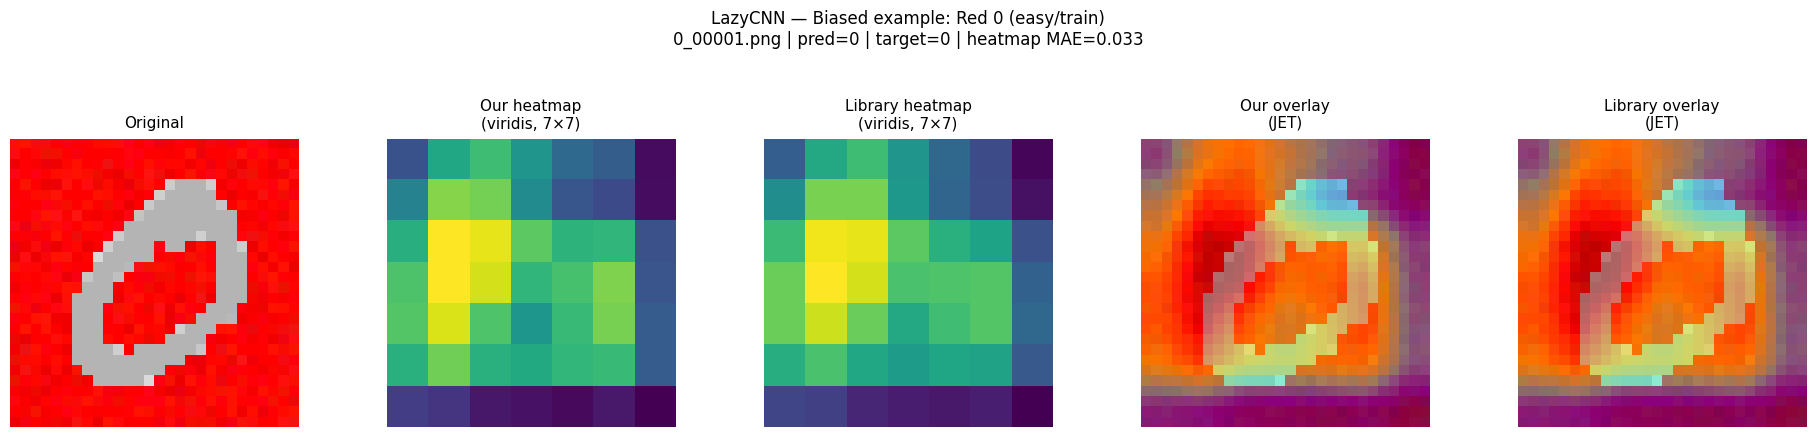

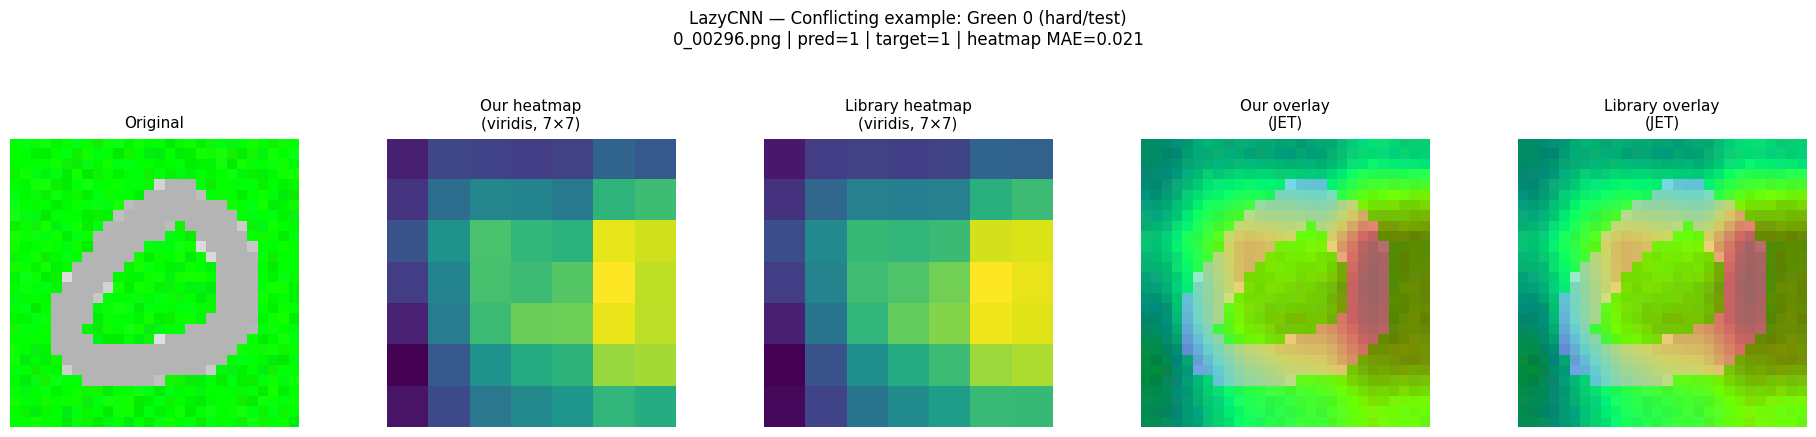

In [50]:
def run_gradcam_row(model_name: str, model: nn.Module, cam_ours: GradCAMScratch, target_layer: nn.Module, img_path: str, case_name: str):
    x, rgb = load_rgb_28(img_path)

    ours = cam_ours(x, target_class=None)  # explain predicted class
    coarse_hw = tuple(ours["heatmap_coarse"].shape)

    lib = gradcam_library(model, x, target_layer, target_class=ours["target_class"], coarse_hw=coarse_hw)

    plot_5panel(
        model_name=model_name,
        case_name=case_name,
        file_name=os.path.basename(img_path),
        rgb=rgb,
        ours_coarse=ours["heatmap_coarse"],
        lib_coarse=lib["heatmap_coarse"],
        ours_up=ours["heatmap_up"],
        lib_up=lib["heatmap_up"],
        pred=ours["pred_class"],
        target=ours["target_class"],
    )

run_gradcam_row("LazyCNN", lazycnn, lazy_cam_ours, lazy_target_layer, RED0_PATH,   "Biased example: Red 0 (easy/train)")
run_gradcam_row("LazyCNN", lazycnn, lazy_cam_ours, lazy_target_layer, GREEN0_PATH, "Conflicting example: Green 0 (hard/test)")

In [51]:
RESNET_CKPT = "/kaggle/input/task3-1r/pytorch/default/1/task1_resnet18_colored_mnist.pth"

resnet = models.resnet18(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

resnet.load_state_dict(torch.load(RESNET_CKPT, map_location=device))
resnet = resnet.to(device).eval()

# IMPORTANT: choose 7x7 layer for 28x28 input (more stable / informative)
resnet_target_layer = resnet.layer1[-1].conv2  # 7x7

# If you want coarser:
# resnet_target_layer = resnet.layer2[-1].conv2  # 4x4

resnet_cam_ours = GradCAMScratch(resnet, resnet_target_layer)

print("ResNet18 loaded:", RESNET_CKPT)
print("ResNet18 target layer:", resnet_target_layer)

ResNet18 loaded: /kaggle/input/task3-1r/pytorch/default/1/task1_resnet18_colored_mnist.pth
ResNet18 target layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [52]:
RED0_PATH   = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/easy_train/0/0_00037.png"
GREEN0_PATH = "/kaggle/input/c2ty2bcoulouredspurious/colored_mnist/type2_background/hard_test/0/0_01191.png"

/tmp/ipykernel_55/3218584559.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat_rgb = cm.get_cmap("jet")(heatmap_0_1)[..., :3].astype(np.float32)


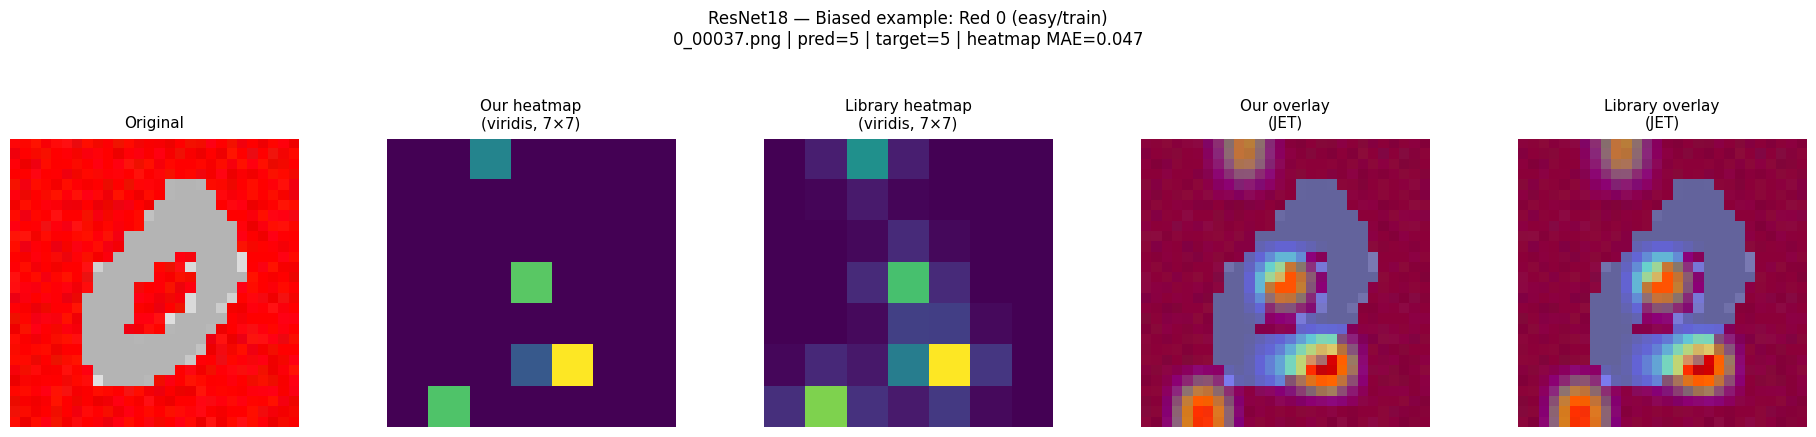

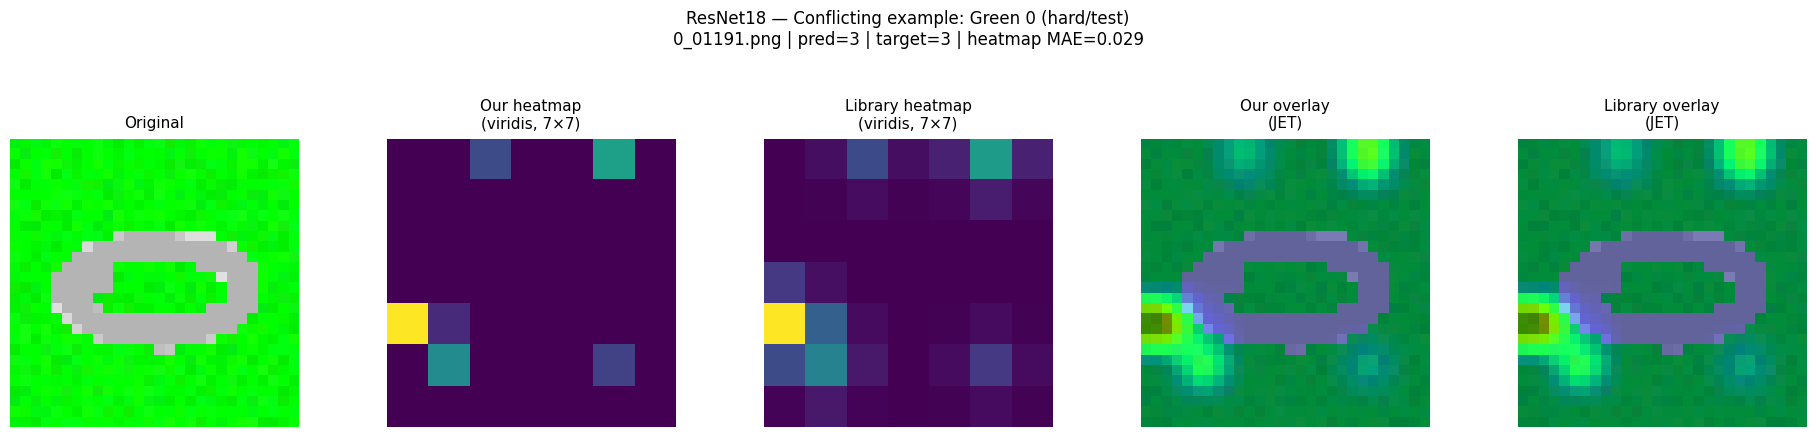

In [53]:
run_gradcam_row("ResNet18", resnet, resnet_cam_ours, resnet_target_layer, RED0_PATH,   "Biased example: Red 0 (easy/train)")
run_gradcam_row("ResNet18", resnet, resnet_cam_ours, resnet_target_layer, GREEN0_PATH, "Conflicting example: Green 0 (hard/test)")

In [37]:
#interpolation problem exists though 
